### Импорт

In [ ]:
!pip install lightly

In [ ]:
!pip install -U giotto-ph

In [ ]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as T

import pytorch_lightning as pl
from lightly.data import LightlyDataset, SimCLRCollateFunction
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.loss import NTXentLoss, BarlowTwinsLoss, NegativeCosineSimilarity
from lightly.models.modules import SimCLRProjectionHead, BarlowTwinsProjectionHead, SimSiamProjectionHead, SimSiamPredictionHead

from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.transforms.simsiam_transform import SimSiamTransform
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from gph.python import ripser_parallel

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.notebook import tqdm
import sys
import io

plt.rcParams.update({'font.size': 10})

### Генерация векторов признаков и эмбэддингов

In [ ]:
def generate_representations_and_embeddings(model, dataloader):
    """
    Input:
        model: trained SSL model
        dataloader: dataloader used while training the model
    Output:
        representations: output of a backbone
        embeddings: output of a projector/predictor
        labels: labels relevant to representations and embeddings
        idxs: indexes from the original dataset
    """
    representations = []
    embeddings = []
    labels = []
    idxs = []
    with torch.no_grad():
        for img, label, index in dataloader:
            img = img.to(model.device)
            y = model.backbone(img).flatten(start_dim=1)
            z = model.projection_head(y)
            representations.append(y)
            embeddings.append(z)
            labels.extend(label)
            idxs.extend(index)


    representations = torch.cat(representations, 0)
    representations = normalize(representations)
    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    labels = list(map(int, labels))
    idxs = list(map(int, idxs))

    return representations, embeddings, labels, idxs

### Визуализация пространства вложения и пространства эмбэддингов, визуализация соседей

In [ ]:
def plot_representations_and_embeddings(representations, embeddings, labels, name, n_dots=2000, dim=2):
    """
    Input:
        representations: output of a backbone
        embeddings: output of a projector/predictor
        labels: labels relevant to representations and embeddings
        name: name of a method
        n_dots: number of visualized dots
    Output:
        2d projection of representations and embeddings
    """
    pca = PCA(n_components=dim)
    repr_dots = pca.fit_transform(representations)
    repr_x = [dot[0] for dot in repr_dots]
    repr_y = [dot[1] for dot in repr_dots]
    emb_dots = pca.fit_transform(embeddings)
    emb_x = [dot[0] for dot in emb_dots]
    emb_y = [dot[1] for dot in emb_dots]

    fig, ax = plt.subplots(nrows=1, ncols=2)
    idxs = np.random.randint(0, len(labels), n_dots)
    cmap = plt.cm.get_cmap('Paired', 12).colors
    for i in idxs:
        ax[0].scatter(repr_x[i], repr_y[i], c=np.array([cmap[labels[i]]]), marker=('${}$'.format(labels[i])))
        ax[1].scatter(emb_x[i], emb_y[i], c=np.array([cmap[labels[i]]]), marker=('${}$'.format(labels[i])))

    ax[0].set_title(f"Проекция векторов признаков, модель {name}.")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[1].set_title(f"Проекция эмбэддингов, модель {name}.")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    fig.set_figheight(7)
    fig.set_figwidth(16)

In [ ]:
def plot_3D(representations, embeddings, labels, name, n_dots=2000):
    """
    Input:
        representations: output of a backbone
        embeddings: output of a projector/predictor
        labels: labels relevant to representations and embeddings
        name: name of a method
        n_dots: number of visualized dots
    Output:
        3d projection of representations and embeddings
    """
    pca = PCA(n_components=3)
    repr_dots = pca.fit_transform(representations)
    repr_x = [dot[0] for dot in repr_dots]
    repr_y = [dot[1] for dot in repr_dots]
    repr_z = [dot[2] for dot in repr_dots]
    emb_dots = pca.fit_transform(embeddings)
    emb_x = [dot[0] for dot in emb_dots]
    emb_y = [dot[1] for dot in emb_dots]
    emb_z = [dot[1] for dot in emb_dots]
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title(f"Проекция репрезентаций, модель {name}.")
    idxs = np.random.randint(0, len(labels), n_dots)
    cmap = plt.cm.get_cmap('Paired', 12).colors
    for i in idxs:
        ax.scatter3D(repr_x[i], repr_y[i], repr_z[i], c=np.array([cmap[labels[i]]]), marker=('${}$'.format(labels[i])))

    ax = fig.add_subplot(122, projection='3d')
    ax.set_title(f"Проекция эмбэддингов, модель {name}.")
    for i in idxs:
        ax.scatter3D(emb_x[i], emb_y[i], emb_z[i], c=np.array([cmap[labels[i]]]), marker=('${}$'.format(labels[i])))



In [ ]:
def plot_neighbours(representations, idxs, name, n_nbrs=3, n_examples=4, index=-1):
    """
    Input:
        representations: data for Nearest Neighbors
        idxs: indexes from the original dataset relevant to data
        name: name of a method
        n_nbrs: number of neighbors for knn
        n_examples: number of examples
        index: find neigbors of dataset[index]
    Output:
        n_examples of n_nbrs nearest neighbors
    """
    find_nbrs = NearestNeighbors(n_neighbors=n_nbrs).fit(representations)
    dist, nbrs = find_nbrs.kneighbors(representations)
    samples_idx = np.random.choice(len(nbrs), size=n_examples, replace=False)

    if index == -1:
        for i in samples_idx:
            fig = plt.figure()
            fig.suptitle(name, y=0.7)
            for j in range(n_nbrs):
                ax = fig.add_subplot(1, len(nbrs[i]), j + 1)
                plt.imshow(np.squeeze(stl10_test[idxs[nbrs[i][j]]][0].permute(1, 2, 0)))
                ax.set_xlabel(f"d={dist[i][j]:.3f}")
    else:
        i = idxs.index(index)
        fig = plt.figure(figsize=(3 * n_nbrs, 7))
        fig.suptitle(name, y=0.7)
        for j in range(n_nbrs):
            ax = fig.add_subplot(1, len(nbrs[i]), j + 1)
            plt.imshow(np.squeeze(stl10_test[idxs[nbrs[i][j]]][0].permute(1, 2, 0)))
            ax.set_xlabel(f"d={dist[i][j]:.3f}")


### Метрики

In [ ]:
def mean_dist(data):
    """
    Input:
        data: representations or embeddings from SSL model
    Output:
        mean distance between 2 nearest neighbors
    """
    find_nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    dist, nbrs = find_nbrs.kneighbors(data)
    total = 0
    for i in range(len(data)):
        total += dist[i][1]
    return total / len(data)

In [ ]:
def mean_dist_same_label(data, idxs):
    """
    Input:
        data: representations or embeddings from SSL model
        idxs: indexes of the original dataset relevent to the given data
    Output:
        mean distance between 2 nearest neighbors of the same class
    """
    find_nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    dist, nbrs = find_nbrs.kneighbors(data)
    total = []
    for i in range(len(data)):
        if stl10_test[idxs[nbrs[i][0]]][1] == stl10_test[idxs[nbrs[i][1]]][1]:
            total.append( dist[i][1])
    return np.mean(total)

In [ ]:
def k_neighbours(data, idxs, n_nbrs=5):
    """
    Input:
        data: representations or embeddings from SSL model
        idxs: indixes of the original dataset relevent to the given data
        n_nbrs: number of nearest neighbors
    Output:
        accuracy of the method meausered with kNN
    """
    find_nbrs = NearestNeighbors(n_neighbors=n_nbrs).fit(data)
    dist, nbrs = find_nbrs.kneighbors(data)
    total = 0
    for i in range(len(data)):
        matches = 0
        for j in range(1, len(nbrs[i])):
            if stl10_test[idxs[nbrs[i][0]]][1] == stl10_test[idxs[nbrs[i][j]]][1]:
                matches += 1
        matches /= (n_nbrs - 1)
        total += matches
    return total / len(data) * 100

In [ ]:
class MLE():
    def __init__(self, k=5, aggregate="mean", eps=1e-6):

        super().__init__()

        self.k = k
        self.eps = eps

        if aggregate=="mean":
            self.aggregate = np.mean
        elif aggregate=="median":
            self.aggregate = np.median
        else:
            raise ValueError("Aggregate function should be 'mean' or 'median'")

    def fit(self, X):

        # get distances within up to the k-th nearest neighor for each point
        nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        distances, _ = nn.kneighbors()
        distances += self.eps # fix duplicate points, causing d(x_i, x_j)=0

        # get local and global intrinsic dimensions
        log_distance_ratios = np.log(distances[:,self.k-1:self.k] / distances[:,:self.k-1])
        self.local_dimension = ((self.k - 2) ** -1 * np.sum(log_distance_ratios, axis=1)) ** -1
        self.dimension = self.aggregate(self.local_dimension)

        return self.dimension

In [ ]:
def find_MLE(X, Y):
    """
    Input:
        X: cloud of representations
        Y: cloud of embeddings
    Output:
        dimensionx, dimensiony: intrinsic dimension estimation
        of the representations space and embeddings space respectively, MLE method
    """
    estimator = MLE()
    dimensionx = estimator.fit(X)
    dimensionx = estimator.dimension
    dimensiony = estimator.fit(Y)
    dimensiony = estimator.dimension
    print(f"Внутренняя размерность репрезентаций, MLE: {dimensionx}")
    print(f"Внутренняя размерность эмбэддингов, MLE: {dimensiony}")
    return dimensionx, dimensiony

In [ ]:
class PCAd():
    def __init__(self, explained_variance=0.95):
        super().__init__()
        self.explained_variance = explained_variance

    def fit(self, X):
        pca = PCA(n_components=self.explained_variance)
        pca.fit(X)
        self.dimension = pca.n_components_

        return self.dimension

In [ ]:
def find_PCAd(X, Y):
    """
    Input:
        X: cloud of representations
        Y: cloud of embeddings
    Output:
        dimensionx, dimensiony: intrinsic dimension estimation
        of the representations space and embeddings space respectively, PCAd method
    """
    estimator = PCAd()
    dimensionx = estimator.fit(X)
    dimensionx = estimator.dimension
    dimensiony = estimator.fit(Y)
    dimensiony = estimator.dimension
    print(f"Внутренняя размерность репрезентаций: {dimensionx}, размерность: {X[0].shape[0]}")
    print(f"Внутренняя размерность эмбэддингов: {dimensiony}, размерность: {Y[0].shape[0]}")
    return dimensionx, dimensiony

In [ ]:
def RTD(P, Q, inf=np.inf, n_jobs=4):
    """
    Input:
        P: cloud of dots from one space
        Q: cloud of dots from another space
        inf: value of infinity
        n_jobs: number of threads
    Output:
        rtd: value of similarity of P with Q
    """

    # compute the joint distance matrix
    D_PP = pairwise_distances(P)
    D_QQ = pairwise_distances(Q)
    D_min_PQ = np.minimum(D_PP, D_QQ)

    D_PP_upper_inf = D_PP.copy()
    D_PP_lower_inf = D_PP.copy()

    upper_triangle_idx = np.triu_indices_from(D_PP, k=1)
    lower_triangle_idx = np.tril_indices_from(D_PP, k=-1)

    D_PP_upper_inf[upper_triangle_idx] = inf
    D_PP_lower_inf[lower_triangle_idx] = inf

    Z = np.zeros_like(D_PP)

    D = np.block([
        [Z, D_PP_lower_inf],
        [D_PP_upper_inf, D_min_PQ]
    ])

    # compute the cross-barcode of the joint distance matrix
    cross_barcode = ripser_parallel(D, metric="precomputed", n_threads=n_jobs)["dgms"]

    # RTD as the "norm" of the cross-barcode (sum of persitences) of dim=1 (normalizing constant?)
    c = 1 / (P.shape[0] + Q.shape[0])
    if len(cross_barcode[1]) == 0:
        rtd = np.nan
    else:
        rtd = np.mean(cross_barcode[1][:,1] - cross_barcode[1][:,0])

    return rtd

In [ ]:
def get_RTD(repr, emb, n_jobs=4):
    """
    Input:
        repr: cloud of reprsentations
        emb: cloud of embeddings
        n_jobs: number of threads
    Output:
        value of similarity of reprsentations with embeddings and vice versa
    """
    rtd_repr_emb, rtd_emb_repr = [], []
    for i in range(0, len(repr), 100):
        x = RTD(repr[i:i+100], emb[i:i+100])
        y = RTD(emb[i:i+100], repr[i:i+100])
        if not np.isnan(x) and not np.isnan(y):
            rtd_repr_emb.append(x)
            rtd_emb_repr.append(y)
    return np.mean(rtd_repr_emb), np.mean(rtd_emb_repr)

### Напечатать лосс

In [ ]:
class PrintLoss(pl.Callback):
    def __init__(self):
        self.epoch = 0

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_loss).mean()
        if self.epoch % 3 == 0:
            print(f"epoch: {self.epoch}, mean_loss:", epoch_mean.item())
        self.epoch += 1
        pl_module.training_step_loss.clear()

## SimCLR

### Датасет

In [ ]:
stl10_train = torchvision.datasets.STL10("../data", split='train', download=True)
stl10_test = torchvision.datasets.STL10("../data", split='test', download=True)

100%|██████████| 2640397119/2640397119 [02:45<00:00, 15909964.13it/s]


Extracting ../data/stl10_binary.tar.gz to ../data
Files already downloaded and verified


In [ ]:
simclr_dataset_train = LightlyDataset.from_torch_dataset(stl10_train, transform=SimCLRTransform(input_size=96))
simclr_dataset_test = LightlyDataset.from_torch_dataset(stl10_test, transform=T.ToTensor())

simclr_dataloader_train = torch.utils.data.DataLoader(
    dataset=simclr_dataset_train,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

simclr_dataloader_test = torch.utils.data.DataLoader(
    dataset=simclr_dataset_test,
    shuffle=True,
    batch_size=64,
    pin_memory=True,
    num_workers=0,
    drop_last=True
)

next(iter(simclr_dataloader_train))[0][0].shape

torch.Size([64, 3, 96, 96])

### Модель SimCLR

In [ ]:
max_epochs = 50

class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.training_step_loss = []

        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.training_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [ ]:
SimCLR_model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", callbacks=[PrintLoss()])
trainer.fit(SimCLR_model, simclr_dataloader_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch: 0, mean_loss: 4.612446308135986
epoch: 3, mean_loss: 4.230302333831787
epoch: 6, mean_loss: 4.068912982940674
epoch: 9, mean_loss: 3.9961187839508057
epoch: 12, mean_loss: 3.925544261932373
epoch: 15, mean_loss: 3.8656702041625977
epoch: 18, mean_loss: 3.8326964378356934
epoch: 21, mean_loss: 3.805006504058838
epoch: 24, mean_loss: 3.7688732147216797
epoch: 27, mean_loss: 3.7645061016082764
epoch: 30, mean_loss: 3.73386287689209
epoch: 33, mean_loss: 3.688689947128296
epoch: 36, mean_loss: 3.6751227378845215
epoch: 39, mean_loss: 3.6633527278900146
epoch: 42, mean_loss: 3.6488306522369385
epoch: 45, mean_loss: 3.634033679962158
epoch: 48, mean_loss: 3.6232171058654785


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Эксперименты

In [ ]:
SimCLR_model.eval()
representations_simclr, embeddings_simclr, labels_simclr, idxs_simclr = generate_representations_and_embeddings(SimCLR_model, simclr_dataloader_test)

<ipython-input-31-f3ee269343a0>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


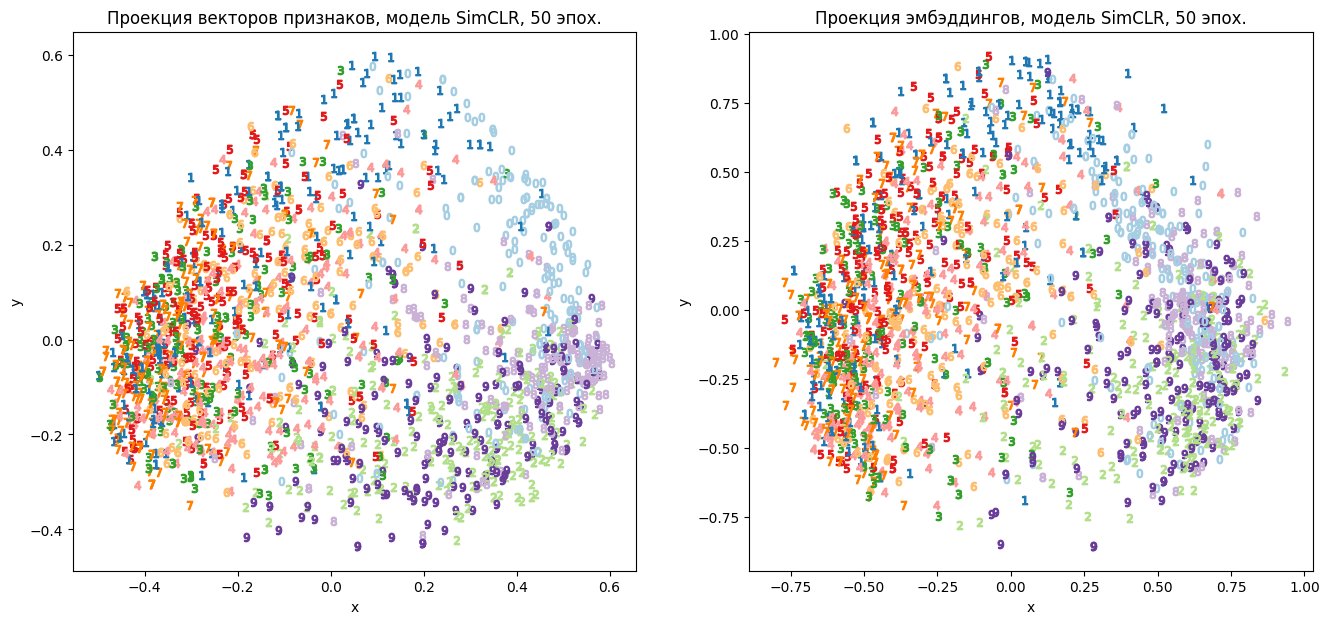

In [ ]:
plot_representations_and_embeddings(representations_simclr, embeddings_simclr, labels_simclr, 'SimCLR, 50 эпох', n_dots=2000)

<ipython-input-7-a2187707d3bf>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


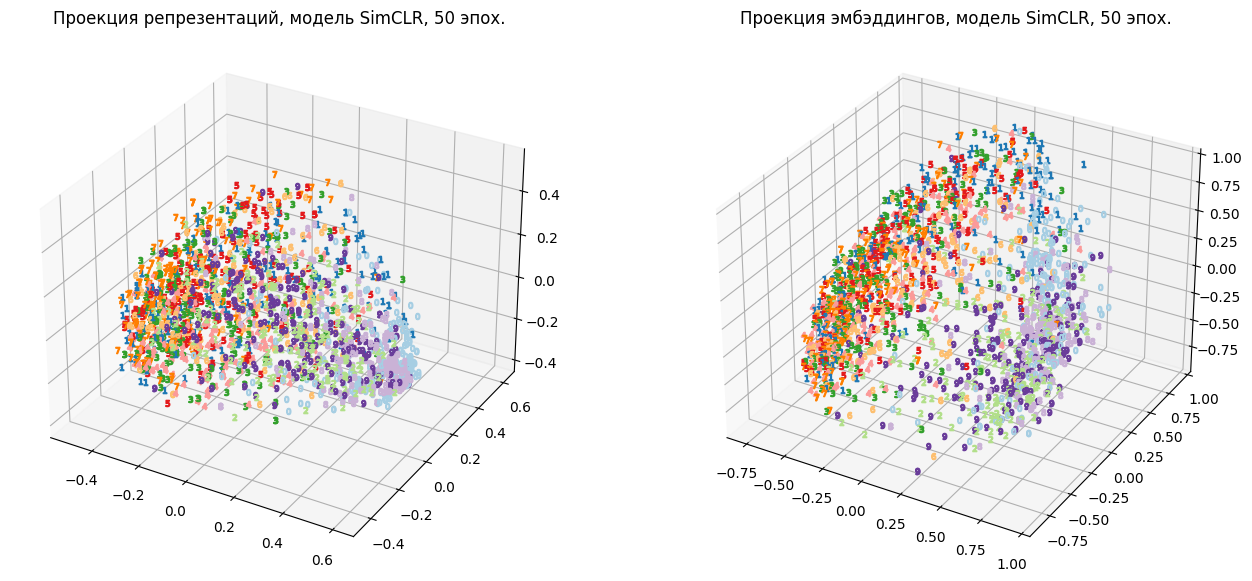

In [ ]:
plot_3D(representations_simclr, embeddings_simclr, labels_simclr, 'SimCLR, 50 эпох', n_dots=2000)

In [ ]:
mean_dist_repr = mean_dist(representations_simclr)
mean_dist_emb = mean_dist(embeddings_simclr)
print("Среднее расстояние между репрезентациями:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами:", mean_dist_emb)

Среднее расстояние между репрезентациями: 0.23013780748139362
Среднее расстояние между эмбэддингами: 0.2616746521893312


In [ ]:
mean_dist_repr = mean_dist_same_label(representations_simclr, idxs_simclr)
mean_dist_emb = mean_dist_same_label(embeddings_simclr, idxs_simclr)
print("Среднее расстояние между репрезентациями, одинаковый лэйбл:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами, одинаковый лэйбл:", mean_dist_emb)

Среднее расстояние между репрезентациями, одинаковый лэйбл: 0.21548466289456691
Среднее расстояние между эмбэддингами, одинаковый лэйбл: 0.2371984906341813


In [ ]:
x_simclr,y_simclr = get_RTD(representations_simclr, embeddings_simclr)

In [ ]:
x_simclr,y_simclr

(0.034967974, 0.14675982)

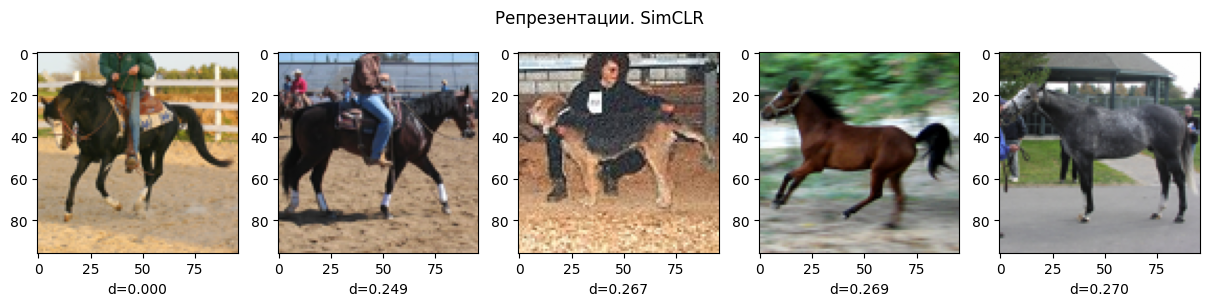

In [ ]:
plot_neighbours(representations_simclr, idxs_simclr, "Репрезентации. SimCLR", index=0, n_nbrs=5)

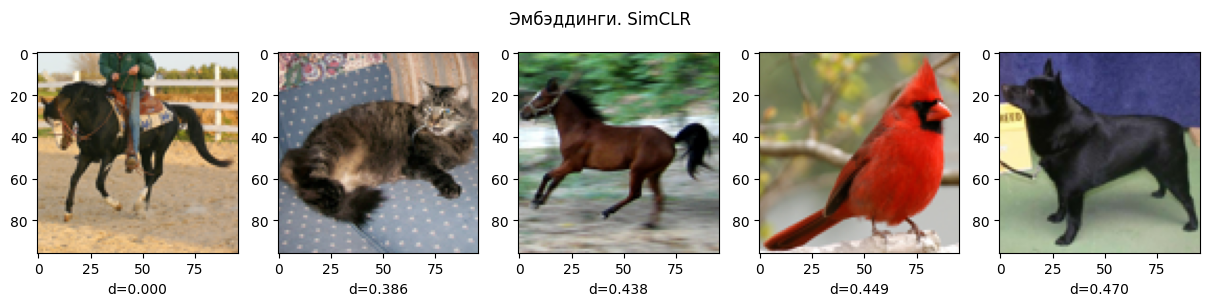

In [ ]:
plot_neighbours(embeddings_simclr, idxs_simclr, "Эмбэддинги. SimCLR", index=0, n_nbrs=5)

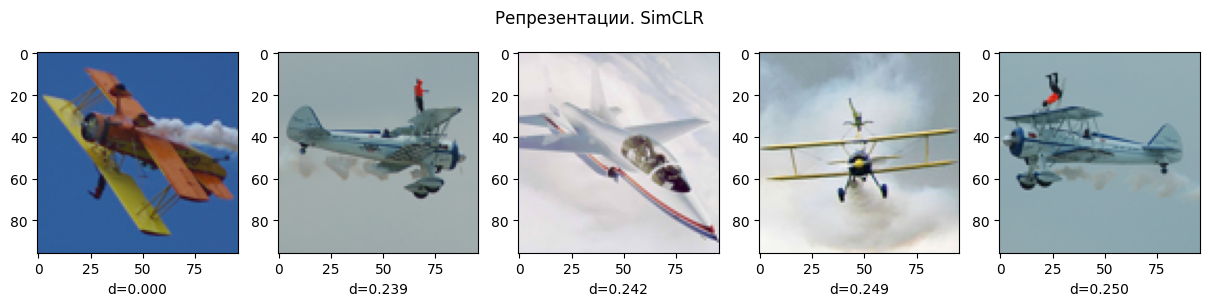

In [ ]:
plot_neighbours(representations_simclr, idxs_simclr, "Репрезентации. SimCLR", index=10, n_nbrs=5)

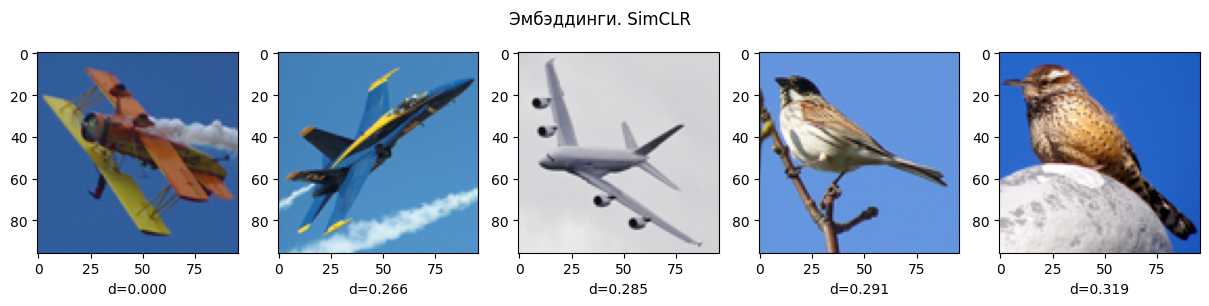

In [ ]:
plot_neighbours(embeddings_simclr, idxs_simclr, "Эмбэддинги. SimCLR", index=10, n_nbrs=5)

In [ ]:
PCAd_repr_simclr, PCAd_emb_simclr = find_PCAd(representations_simclr, embeddings_simclr)

Внутренняя размерность репрезентаций: 37, размерность: 512
Внутренняя размерность эмбэддингов: 10, размерность: 128


In [ ]:
acc_repr = k_neighbours(representations_simclr, idxs_simclr)
print(f"Процент совпадения, репрезентации, k=5: {acc_repr}%")
acc_emb = k_neighbours(embeddings_simclr, idxs_simclr)
print(f"Процент совпадения, эмбеддинги, k=5: {acc_emb}%")

Процент совпадения, репрезентации, k=5: 41.55%
Процент совпадения, эмбеддинги, k=5: 38.053125%


In [ ]:
acc_repr = k_neighbours(representations_simclr, idxs_simclr, n_nbrs=2)
print(f"Процент совпадения, репрезентации, k=2: {acc_repr}%")
acc_emb = k_neighbours(embeddings_simclr, idxs_simclr, n_nbrs=2)
print(f"Процент совпадения, эмбеддинги, k=2: {acc_emb}%")

Процент совпадения, репрезентации, k=2: 44.375%
Процент совпадения, эмбеддинги, k=2: 40.550000000000004%


In [ ]:
find_MLE(representations_simclr, embeddings_simclr)

Внутренняя размерность репрезентаций, MLE: 12.852855043869438
Внутренняя размерность эмбэддингов, MLE: 6.651863995365019


(12.852855043869438, 6.651863995365019)

## Barlow Twins

### Датасет

In [ ]:
BT_dataset_train = LightlyDataset.from_torch_dataset(stl10_train, transform=SimCLRTransform(input_size=96))
BT_dataset_test = LightlyDataset.from_torch_dataset(stl10_test, transform=T.ToTensor())

BT_dataloader_train = torch.utils.data.DataLoader(
    dataset=BT_dataset_train,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

BT_dataloader_test = torch.utils.data.DataLoader(
    dataset=BT_dataset_test,
    shuffle=True,
    batch_size=64,
    pin_memory=True,
    num_workers=0,
    drop_last=True
)

### Модель Barlow Twins

In [ ]:
max_epochs = 50

class BarlowTwinsModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.training_step_loss = []

        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        in_dim = resnet.fc.in_features
        self.projection_head = BarlowTwinsProjectionHead(in_dim, in_dim, 128)

        self.criterion = BarlowTwinsLoss()

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.training_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [ ]:
BT_model = BarlowTwinsModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", callbacks=[PrintLoss()])
trainer.fit(BT_model, BT_dataloader_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                      | Params
--------------------------------------------------------------
0 | backbone        | Sequential                | 11.2 M
1 | projection_head | BarlowTwinsProjectionHead | 592 K 
2 | criterion       | BarlowTwinsLoss           | 0     
--------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.074    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch: 0, mean_loss: 93.42915344238281
epoch: 3, mean_loss: 59.90837860107422
epoch: 6, mean_loss: 52.84362030029297
epoch: 9, mean_loss: 43.99729537963867
epoch: 12, mean_loss: 37.362998962402344
epoch: 15, mean_loss: 33.73114776611328
epoch: 18, mean_loss: 31.808237075805664
epoch: 21, mean_loss: 30.048816680908203
epoch: 24, mean_loss: 27.964086532592773
epoch: 27, mean_loss: 27.086572647094727
epoch: 30, mean_loss: 25.648330688476562
epoch: 33, mean_loss: 25.631502151489258
epoch: 36, mean_loss: 24.780351638793945
epoch: 39, mean_loss: 24.526060104370117
epoch: 42, mean_loss: 24.621360778808594
epoch: 45, mean_loss: 23.966665267944336
epoch: 48, mean_loss: 24.04450225830078


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Эксперименты

In [ ]:
BT_model.eval()
representations_bt, embeddings_bt, labels_bt, idxs_bt = generate_representations_and_embeddings(BT_model, BT_dataloader_test)

<ipython-input-31-f3ee269343a0>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


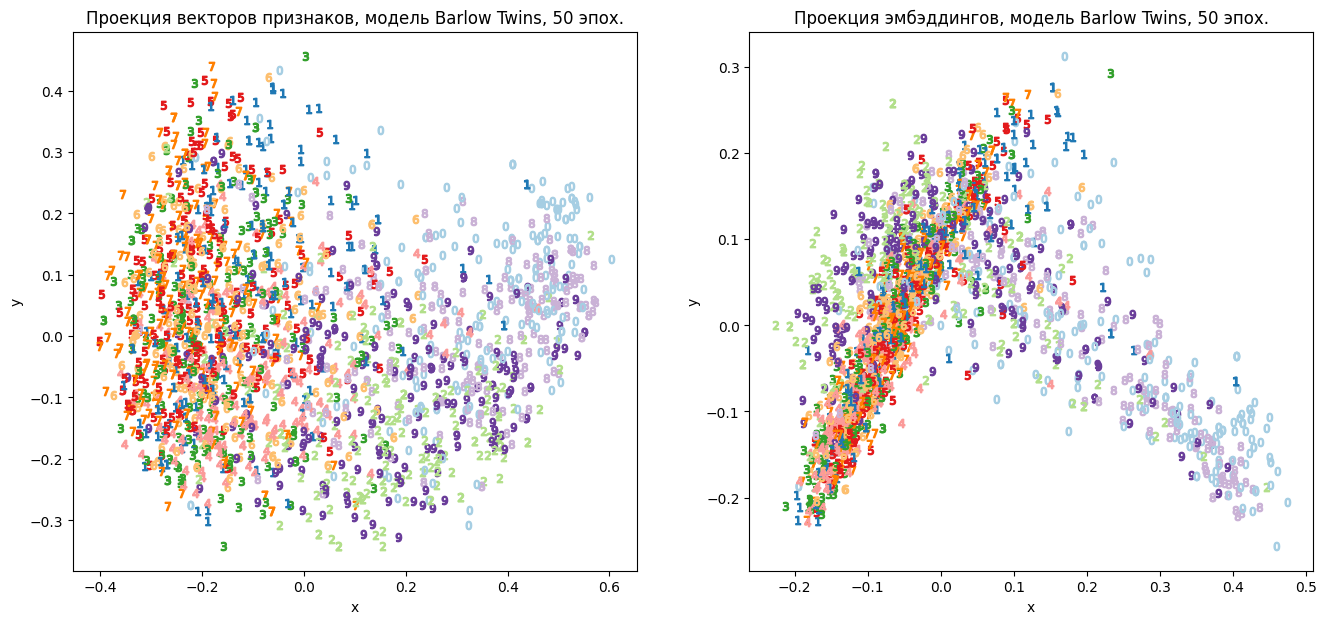

In [ ]:
plot_representations_and_embeddings(representations_bt, embeddings_bt, labels_bt, 'Barlow Twins, 50 эпох')

<ipython-input-7-a2187707d3bf>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


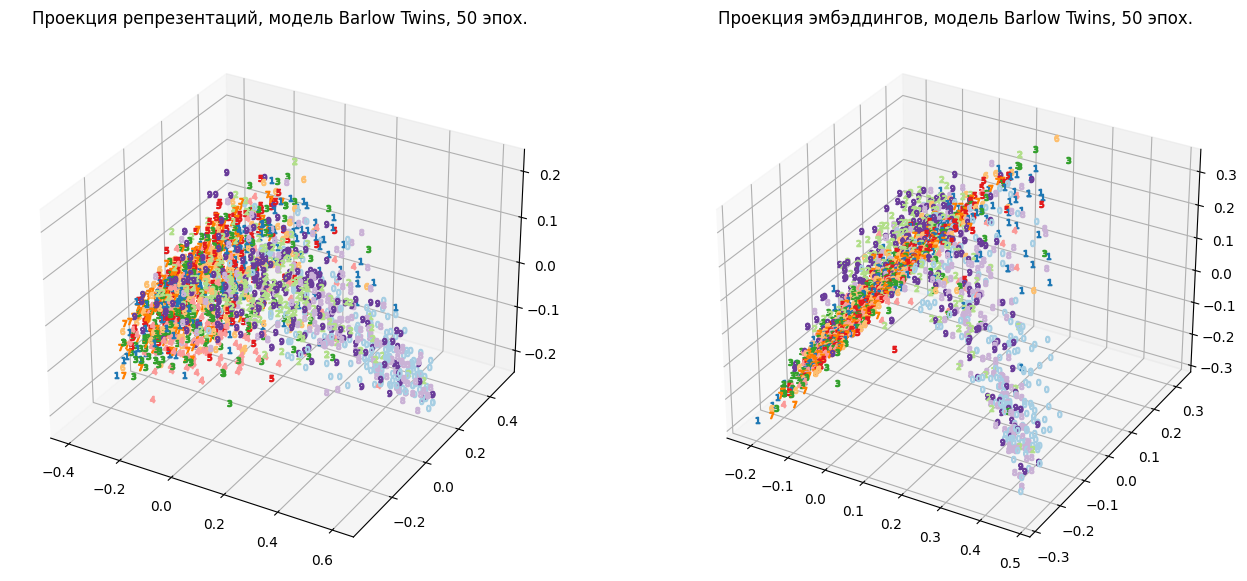

In [ ]:
plot_3D(representations_bt, embeddings_bt, labels_bt, 'Barlow Twins, 50 эпох', n_dots=2000)

In [ ]:
mean_dist_repr = mean_dist(representations_bt)
mean_dist_emb = mean_dist(embeddings_bt)
print("Среднее расстояние между репрезентациями:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами:", mean_dist_emb)

Среднее расстояние между репрезентациями: 0.07111401626494637
Среднее расстояние между эмбэддингами: 0.007519405082713712


In [ ]:
mean_dist_repr = mean_dist_same_label(representations_bt, idxs_bt)
mean_dist_emb = mean_dist_same_label(embeddings_bt, idxs_bt)
print("Среднее расстояние между репрезентациями, одинаковый лэйбл:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами, одинаковый лэйбл:", mean_dist_emb)

Среднее расстояние между репрезентациями, одинаковый лэйбл: 0.06756437103763309
Среднее расстояние между эмбэддингами, одинаковый лэйбл: 0.008276452745962094


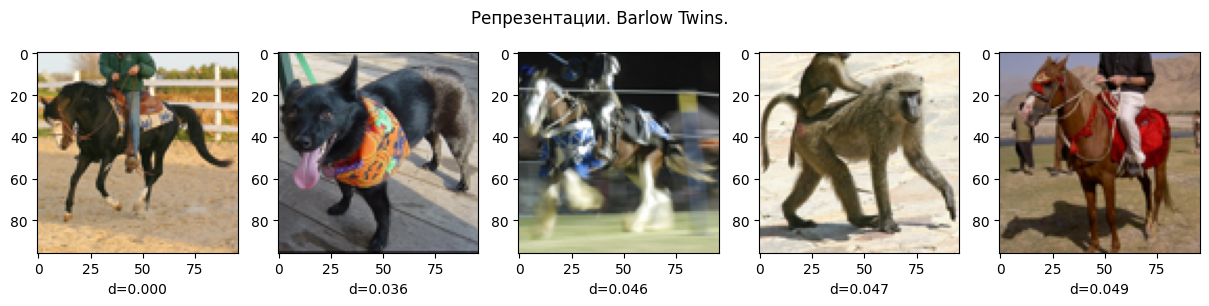

In [ ]:
plot_neighbours(representations_bt, idxs_bt, "Репрезентации. Barlow Twins.", index=0, n_nbrs=5)

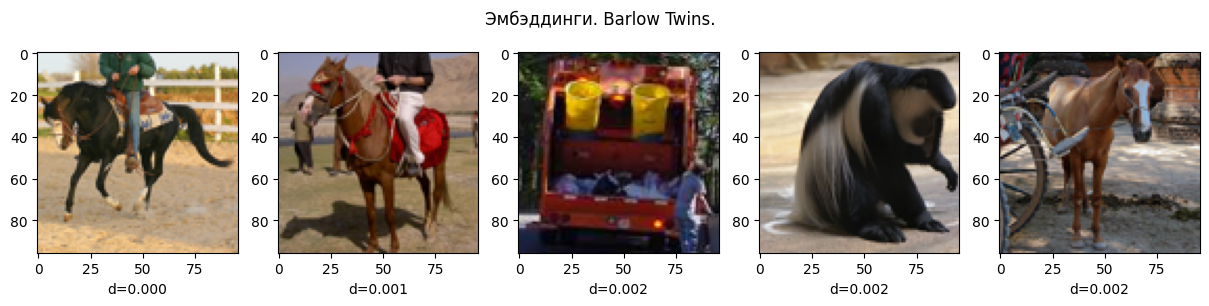

In [ ]:
plot_neighbours(embeddings_bt, idxs_bt, "Эмбэддинги. Barlow Twins.", index=0, n_nbrs=5)

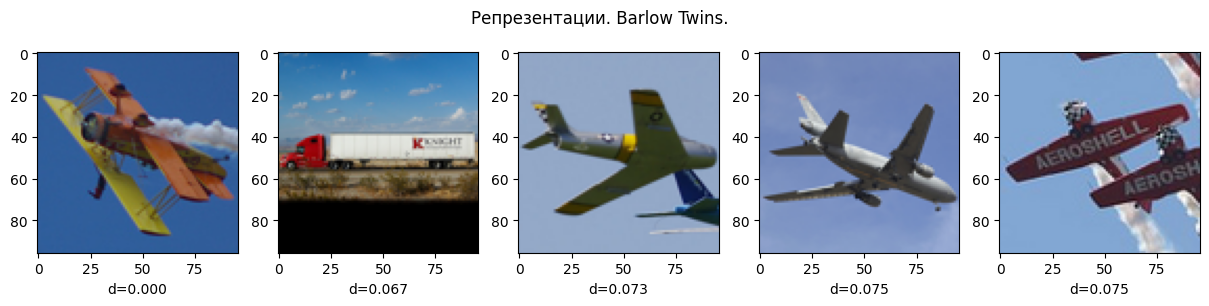

In [ ]:
plot_neighbours(representations_bt, idxs_bt, "Репрезентации. Barlow Twins.", index=10, n_nbrs=5)

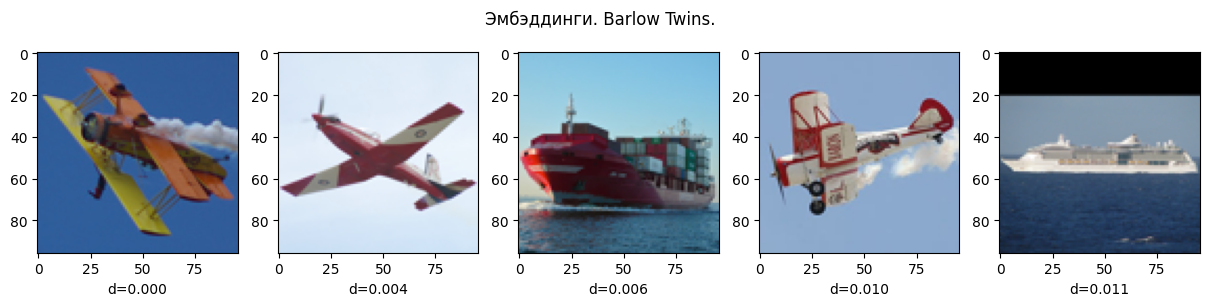

In [ ]:
plot_neighbours(embeddings_bt, idxs_bt, "Эмбэддинги. Barlow Twins.", index=10, n_nbrs=5)

In [ ]:
PCAd_repr_bt, PCAd_emb_bt = find_PCAd(representations_bt, embeddings_bt)

Внутренняя размерность репрезентаций: 5, размерность: 512
Внутренняя размерность эмбэддингов: 3, размерность: 128


In [ ]:
x_bt, y_bt = get_RTD(representations_bt, embeddings_bt)

In [ ]:
x_bt, y_bt

(0.06749094, 0.010234045)

In [ ]:
acc_repr = k_neighbours(representations_bt, idxs_bt)
print(f"Процент совпадения, репрезентации, knn: {acc_repr}%")
acc_emb = k_neighbours(embeddings_bt, idxs_bt)
print(f"Процент совпадения, эмбеддинги, knn: {acc_emb}%")

Процент совпадения, репрезентации, knn: 28.965625%
Процент совпадения, эмбеддинги, knn: 23.884375%


In [ ]:
acc_repr = k_neighbours(representations_bt, idxs_bt, n_nbrs=2)
print(f"Процент совпадения, репрезентации, k=2: {acc_repr}%")
acc_emb = k_neighbours(embeddings_bt, idxs_bt, n_nbrs=2)
print(f"Процент совпадения, эмбеддинги, k=2: {acc_emb}%")

Процент совпадения, репрезентации, k=2: 31.662499999999998%
Процент совпадения, эмбеддинги, k=2: 23.65%


In [ ]:
find_MLE(representations_bt, embeddings_bt)

Внутренняя размерность репрезентаций, MLE: 12.471866003376865
Внутренняя размерность эмбэддингов, MLE: 3.1355792760786625


(12.471866003376865, 3.1355792760786625)

## SimSiam

### Датасет

In [ ]:
simsiam_dataset_train = LightlyDataset.from_torch_dataset(stl10_train, transform=SimSiamTransform(input_size=96))
simsiam_dataset_test = LightlyDataset.from_torch_dataset(stl10_test, transform=T.ToTensor())

simsiam_dataloader_train = torch.utils.data.DataLoader(
    dataset=simsiam_dataset_train,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

simsiam_dataloader_test = torch.utils.data.DataLoader(
    dataset=simsiam_dataset_test,
    shuffle=True,
    batch_size=64,
    pin_memory=True,
    num_workers=0,
    drop_last=True
)

### Модель SimSiam

In [ ]:
max_epochs = 50

class SimSiamModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.training_step_loss = []

        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimSiamProjectionHead(hidden_dim, hidden_dim, 128)
        self.prediction_head = SimSiamPredictionHead(128, 64, 128)

        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0, p0 = self.forward(x0)
        z1, p1 = self.forward(x1)
        loss = 0.5 * (self.criterion(z0, p1) + self.criterion(z1, p0))
        self.training_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [ ]:
SimSiam_model = SimSiamModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", callbacks=[PrintLoss()])
trainer.fit(SimSiam_model, simsiam_dataloader_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                     | Params
-------------------------------------------------------------
0 | backbone        | Sequential               | 11.2 M
1 | projection_head | SimSiamProjectionHead    | 591 K 
2 | prediction_head | SimSiamPredictionHead    | 16.6 K
3 | criterion       | NegativeCosineSimilarity | 0     
-------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.140    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch: 0, mean_loss: -0.4368653893470764
epoch: 3, mean_loss: -0.6862869262695312
epoch: 6, mean_loss: -0.7143834233283997
epoch: 9, mean_loss: -0.7630854249000549
epoch: 12, mean_loss: -0.7822793126106262
epoch: 15, mean_loss: -0.7991310954093933
epoch: 18, mean_loss: -0.8049794435501099
epoch: 21, mean_loss: -0.8095486164093018
epoch: 24, mean_loss: -0.8019647598266602
epoch: 27, mean_loss: -0.8218870759010315
epoch: 30, mean_loss: -0.8233528137207031
epoch: 33, mean_loss: -0.8306270837783813
epoch: 36, mean_loss: -0.8315507173538208
epoch: 39, mean_loss: -0.8398409485816956
epoch: 42, mean_loss: -0.8362575769424438
epoch: 45, mean_loss: -0.8405546545982361
epoch: 48, mean_loss: -0.8428968787193298


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Эксперименты

In [ ]:
SimSiam_model.eval()
representations_simsiam, embeddings_simsiam, labels_simsiam, idxs_simsiam = generate_representations_and_embeddings(SimSiam_model, simsiam_dataloader_test)

<ipython-input-31-f3ee269343a0>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


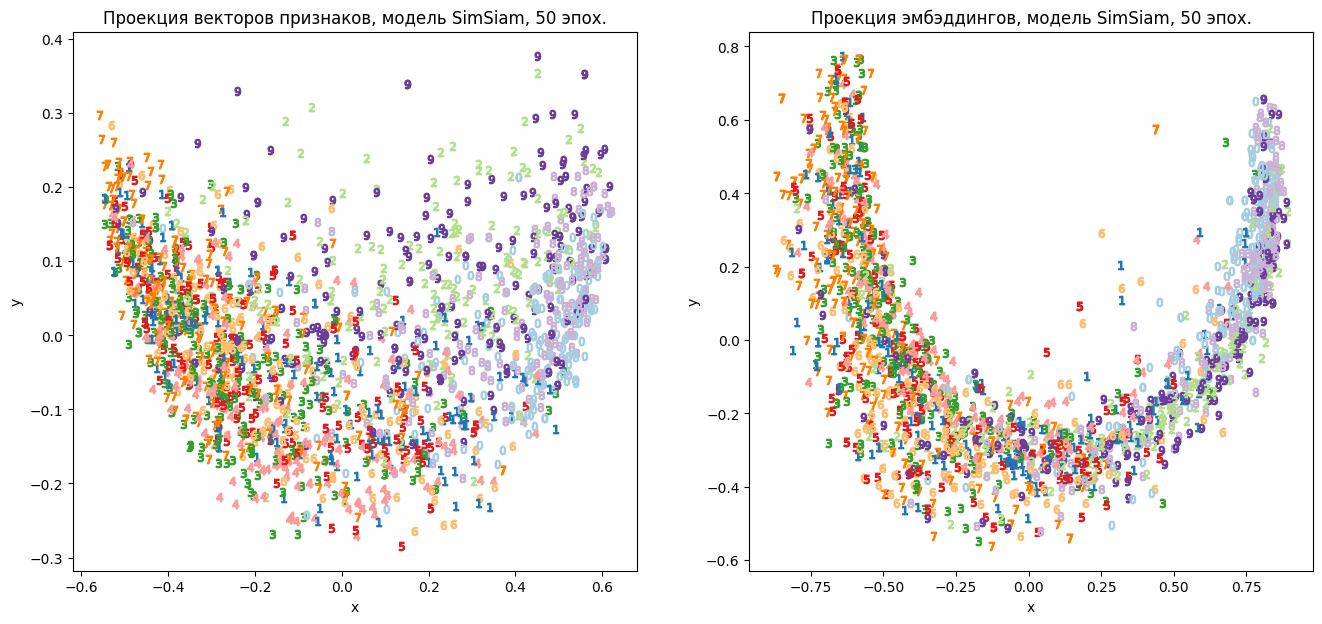

In [ ]:
plot_representations_and_embeddings(representations_simsiam, embeddings_simsiam, labels_simsiam, 'SimSiam, 50 эпох')

<ipython-input-7-a2187707d3bf>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


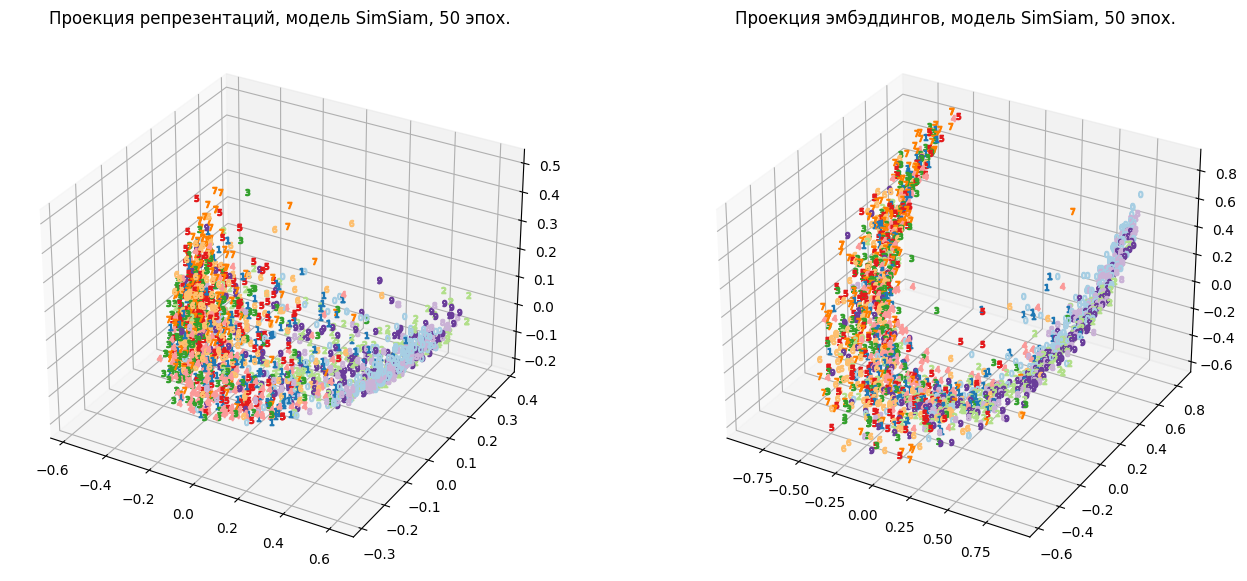

In [ ]:
plot_3D(representations_simsiam, embeddings_simsiam, labels_simsiam, 'SimSiam, 50 эпох', n_dots=2000)

In [ ]:
mean_dist_repr = mean_dist(representations_simsiam)
mean_dist_emb = mean_dist(embeddings_simsiam)
print("Среднее расстояние между репрезентациями:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами:", mean_dist_emb)

Среднее расстояние между репрезентациями: 0.16746088703787426
Среднее расстояние между эмбэддингами: 0.06715548475335004


In [ ]:
mean_dist_repr = mean_dist_same_label(representations_simsiam, idxs_simsiam)
mean_dist_emb = mean_dist_same_label(embeddings_simsiam, idxs_simsiam)
print("Среднее расстояние между репрезентациями, одинаковый лэйбл:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами, одинаковый лэйбл:", mean_dist_emb)

Среднее расстояние между репрезентациями, одинаковый лэйбл: 0.15973163142632238
Среднее расстояние между эмбэддингами, одинаковый лэйбл: 0.06255454732807518


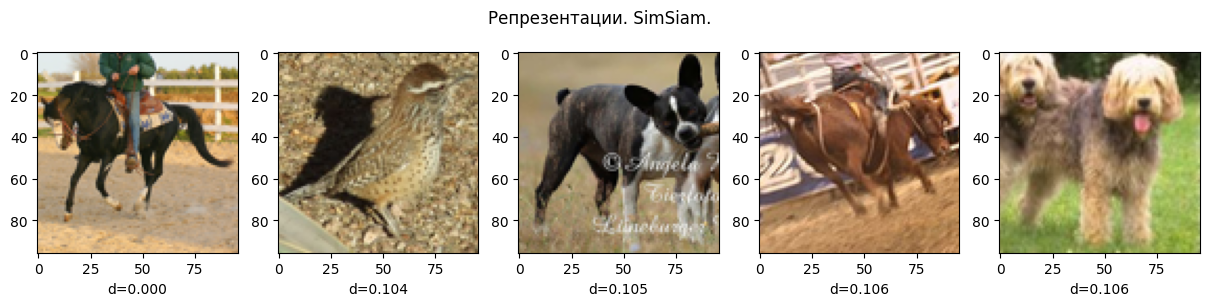

In [ ]:
plot_neighbours(representations_simsiam, idxs_simsiam, "Репрезентации. SimSiam.", index=0, n_nbrs=5)

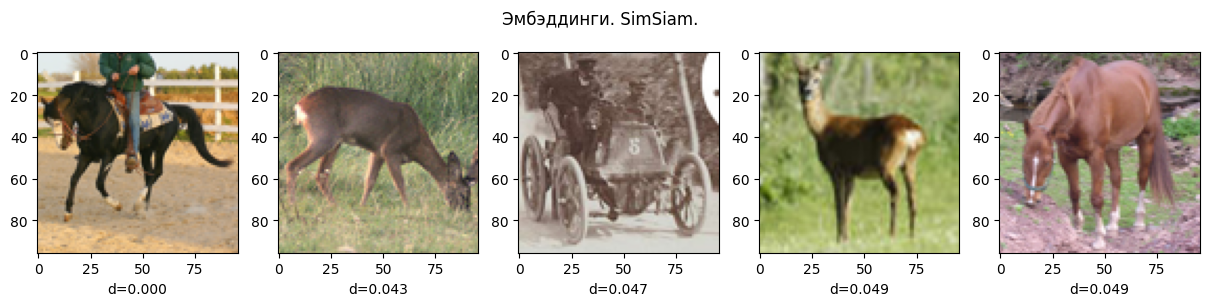

In [ ]:
plot_neighbours(embeddings_simsiam, idxs_simsiam, "Эмбэддинги. SimSiam.", index=0, n_nbrs=5)

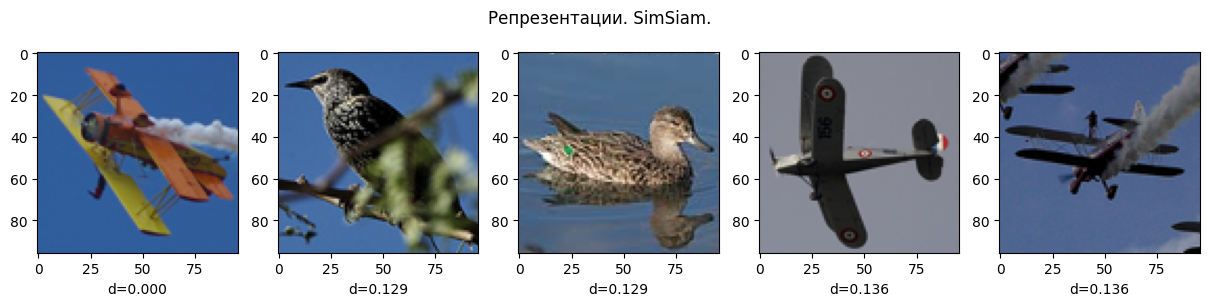

In [ ]:
plot_neighbours(representations_simsiam, idxs_simsiam, "Репрезентации. SimSiam.", index=10, n_nbrs=5)

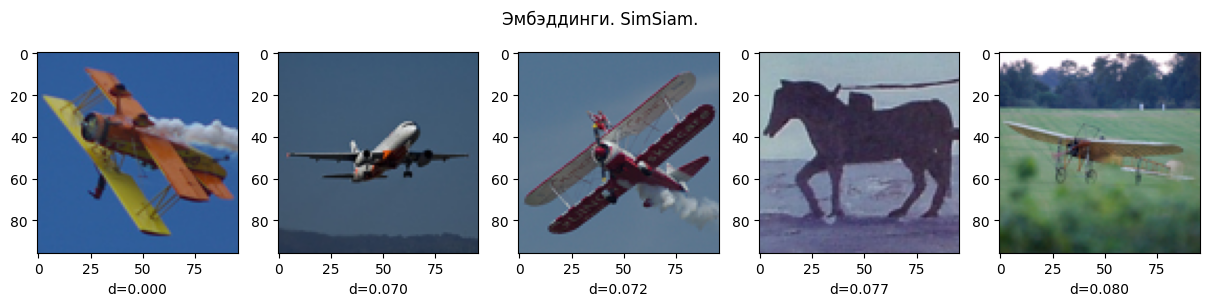

In [ ]:
plot_neighbours(embeddings_simsiam, idxs_simsiam, "Эмбэддинги. SimSiam.", index=10, n_nbrs=5)

In [ ]:
PCAd_repr_simsiam, PCAd_emb_simsiam = find_PCAd(representations_simsiam, embeddings_simsiam)

Внутренняя размерность репрезентаций: 64, размерность: 512
Внутренняя размерность эмбэддингов: 4, размерность: 128


In [ ]:
x_simsiam, y_simsiam = get_RTD(representations_simsiam, embeddings_simsiam)

In [ ]:
x_simsiam, y_simsiam

(0.06344924, 0.037972204)

In [ ]:
acc_repr = k_neighbours(representations_simsiam, idxs_simsiam)
print(f"Процент совпадения, репрезентации, knn: {acc_repr}%")
acc_emb = k_neighbours(embeddings_simsiam, idxs_simsiam)
print(f"Процент совпадения, эмбеддинги, knn: {acc_emb}%")

Процент совпадения, репрезентации, knn: 34.840624999999996%
Процент совпадения, эмбеддинги, knn: 26.065624999999997%


In [ ]:
acc_repr = k_neighbours(representations_simsiam, idxs_simsiam, n_nbrs=2)
print(f"Процент совпадения, репрезентации, k=2: {acc_repr}%")
acc_emb = k_neighbours(embeddings_simsiam, idxs_simsiam, n_nbrs=2)
print(f"Процент совпадения, эмбеддинги, k=2: {acc_emb}%")

Процент совпадения, репрезентации, k=2: 38.2125%
Процент совпадения, эмбеддинги, k=2: 28.212500000000002%


In [ ]:
find_MLE(representations_simsiam, embeddings_simsiam )

Внутренняя размерность репрезентаций, MLE: 23.199080479700793
Внутренняя размерность эмбэддингов, MLE: 6.69208865065842


(23.199080479700793, 6.69208865065842)

## ESSL, rotations

### Датасет

In [ ]:
class ESSL_Transform:
    def __init__(self):
        self.transform_SimCLR = SimCLRTransform(input_size=32)

    def __call__(self, x):
        tensor_transform = T.ToTensor()
        output = self.transform_SimCLR(x)
        output.append(tensor_transform(x))
        return output

In [ ]:
essl_dataset_train = LightlyDataset.from_torch_dataset(stl10_train, transform=ESSL_Transform())
essl_dataset_test = LightlyDataset.from_torch_dataset(stl10_test, transform=T.ToTensor())

essl_dataloader_train = torch.utils.data.DataLoader(
    dataset=essl_dataset_train,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

essl_dataloader_test = torch.utils.data.DataLoader(
    dataset=essl_dataset_test,
    shuffle=True,
    batch_size=64,
    pin_memory=True,
    num_workers=0,
    drop_last=True
)

next(iter(essl_dataloader_train))[0][0].shape

torch.Size([64, 3, 32, 32])

In [ ]:
def rotate4_images(images):
    nimages = images.shape[0]
    n_rot_images = 4 * nimages

    rotated_images = torch.zeros([n_rot_images, images.shape[1], images.shape[2], images.shape[3]])
    rot_classes = torch.zeros([n_rot_images]).long()

    rotated_images[:nimages] = images
    rotated_images[nimages:2 * nimages] = images.flip(3).transpose(2, 3)
    rot_classes[nimages:2 * nimages] = 1
    rotated_images[2 * nimages:3 * nimages] = images.flip(3).flip(2)
    rot_classes[2 * nimages:3 * nimages] = 2
    rotated_images[3 * nimages:4 * nimages] = images.transpose(2, 3).flip(3)
    rot_classes[3 * nimages:4 * nimages] = 3

    return rotated_images.cuda(), rot_classes.cuda()

### Модель E-SSL

In [ ]:
max_epochs = 50
lmbd = 0.4

class ESSLModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.training_step_loss = []

        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)
        self.predictor = nn.Sequential(nn.Linear(512, 1024),
                                        nn.LayerNorm(1024),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(1024, 1024),
                                        nn.LayerNorm(1024),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(1024, 4))

        self.criterion = NTXentLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1) # representation
        z = self.projection_head(x) # embedding
        return z

    def training_step(self, batch, batch_idx):
        data, labels, _ = batch
        x1 = data[0].cuda() # 1st view
        x2 = data[1].cuda() # 2nd view
        z1 = self.forward(x1)
        z2 = self.forward(x2)
        loss = self.criterion(z1, z2)

        rotated_images, rotated_labels = rotate4_images(data[2])
        y = self.backbone(rotated_images).squeeze()
        logits = self.predictor(y)
        equiv_loss = nn.functional.cross_entropy(logits, rotated_labels)
        loss += lmbd * equiv_loss
        self.training_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [ ]:
ESSL_model = ESSLModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", callbacks=[PrintLoss()])
trainer.fit(ESSL_model, essl_dataloader_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | predictor       | Sequential           | 1.6 M 
3 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.354    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch: 0, mean_loss: 5.513814926147461
epoch: 3, mean_loss: 4.756032943725586
epoch: 6, mean_loss: 4.515444278717041
epoch: 9, mean_loss: 4.324826717376709
epoch: 12, mean_loss: 4.189246654510498
epoch: 15, mean_loss: 4.130387783050537
epoch: 18, mean_loss: 4.0665974617004395
epoch: 21, mean_loss: 4.054964065551758
epoch: 24, mean_loss: 4.011707782745361
epoch: 27, mean_loss: 3.972564697265625
epoch: 30, mean_loss: 3.9405436515808105
epoch: 33, mean_loss: 3.9156839847564697
epoch: 36, mean_loss: 3.8929004669189453
epoch: 39, mean_loss: 3.8795177936553955
epoch: 42, mean_loss: 3.8758909702301025
epoch: 45, mean_loss: 3.8668875694274902
epoch: 48, mean_loss: 3.8421435356140137


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Эксперименты

In [ ]:
ESSL_model.eval()
representations_essl, embeddings_essl, labels_essl, idxs_essl = generate_representations_and_embeddings(ESSL_model, essl_dataloader_test)

<ipython-input-31-f3ee269343a0>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


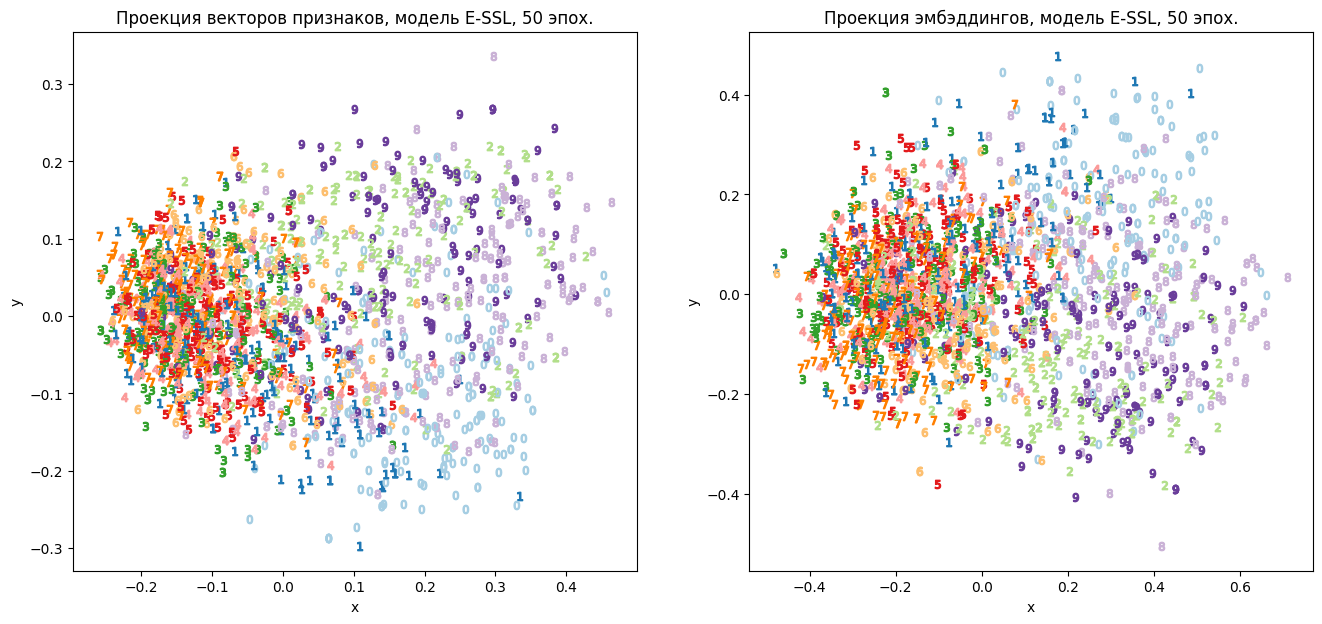

In [ ]:
plot_representations_and_embeddings(representations_essl, embeddings_essl, labels_essl, 'E-SSL, 50 эпох')

<ipython-input-7-a2187707d3bf>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 12).colors


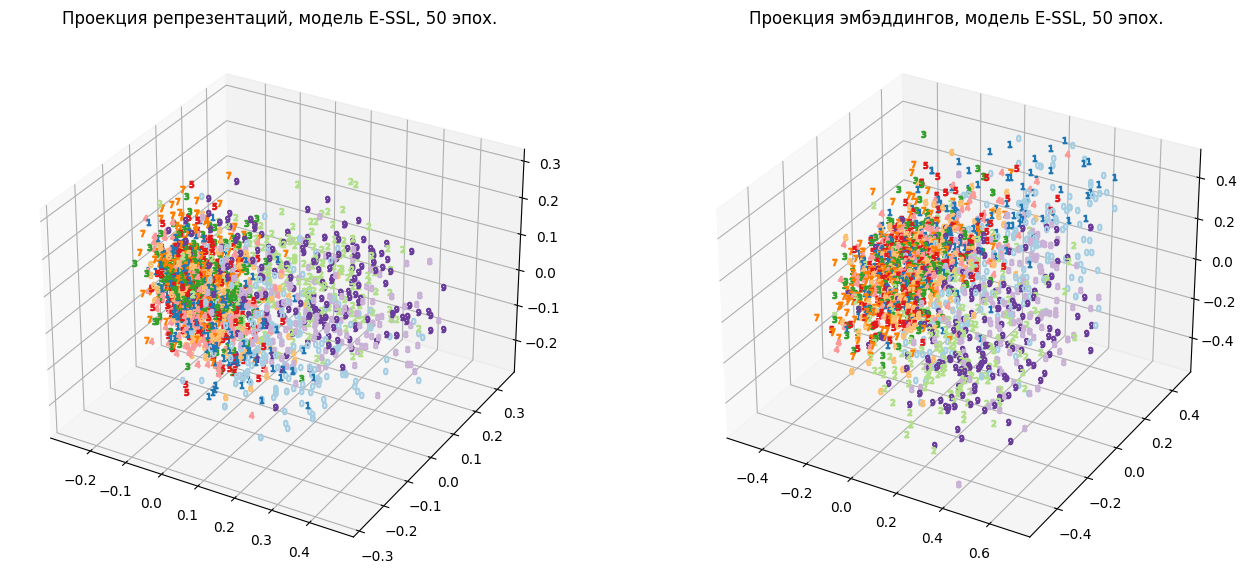

In [ ]:
plot_3D(representations_essl, embeddings_essl, labels_essl, 'E-SSL, 50 эпох', n_dots=2000)

In [ ]:
mean_dist_repr = mean_dist(representations_essl)
mean_dist_emb = mean_dist(embeddings_essl)
print("Среднее расстояние между репрезентациями:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами:", mean_dist_emb)

Среднее расстояние между репрезентациями: 0.2391282856562178
Среднее расстояние между эмбэддингами: 0.08902336710098767


In [ ]:
mean_dist_repr = mean_dist_same_label(representations_essl, idxs_essl)
mean_dist_emb = mean_dist_same_label(embeddings_essl, idxs_essl)
print("Среднее расстояние между репрезентациями, одинаковый лэйбл:", mean_dist_repr)
print("Среднее расстояние между эмбэддингами, одинаковый лэйбл:", mean_dist_emb)

Среднее расстояние между репрезентациями, одинаковый лэйбл: 0.2350737055393115
Среднее расстояние между эмбэддингами, одинаковый лэйбл: 0.09133932634709221


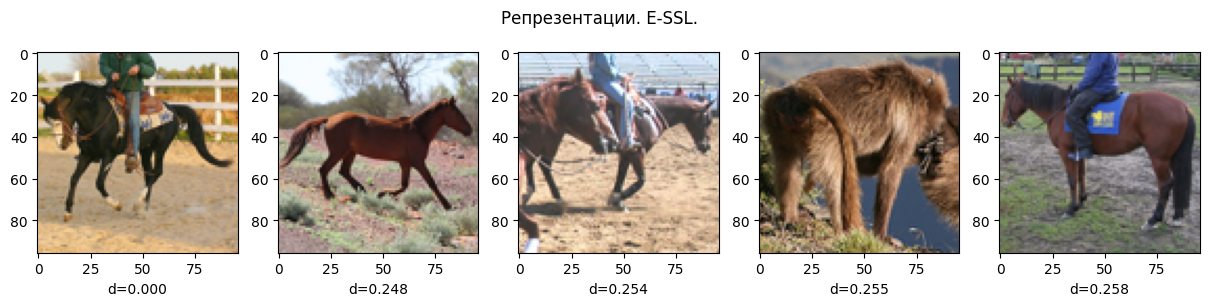

In [ ]:
plot_neighbours(representations_essl, idxs_essl, "Репрезентации. E-SSL.", index=0, n_nbrs=5)

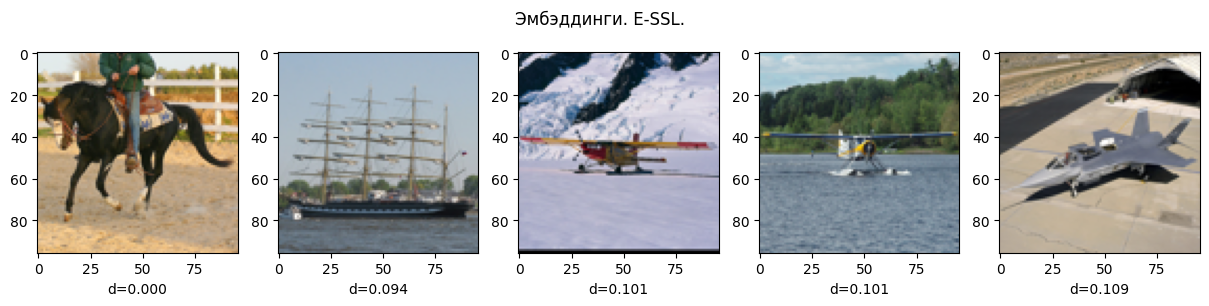

In [ ]:
plot_neighbours(embeddings_essl, idxs_essl, "Эмбэддинги. E-SSL.", index=0, n_nbrs=5)

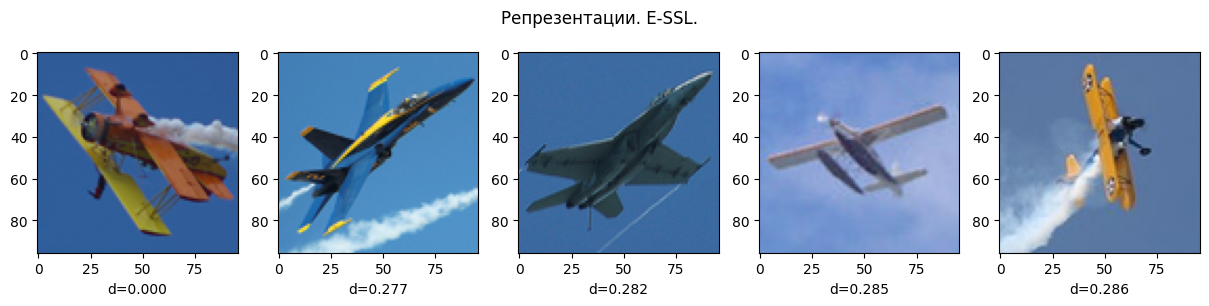

In [ ]:
plot_neighbours(representations_essl, idxs_essl, "Репрезентации. E-SSL.", index=10, n_nbrs=5)

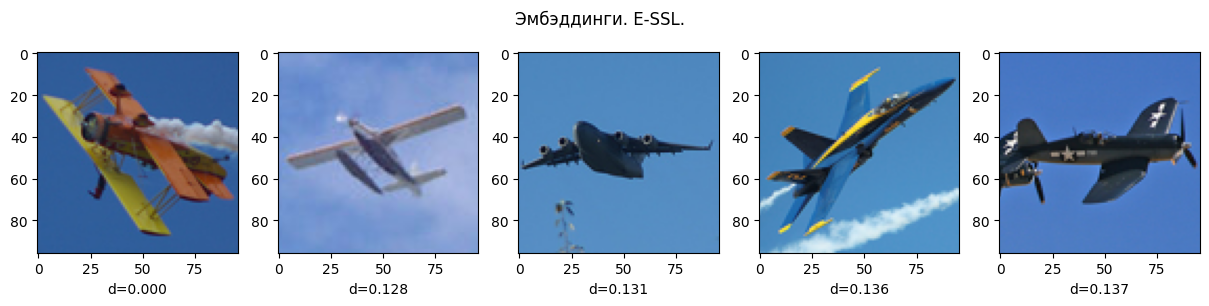

In [ ]:
plot_neighbours(embeddings_essl, idxs_essl, "Эмбэддинги. E-SSL.", index=10, n_nbrs=5)

In [ ]:
PCAd_repr_essl, PCAd_emb_essl = find_PCAd(representations_essl, embeddings_essl)

Внутренняя размерность репрезентаций: 233, размерность: 512
Внутренняя размерность эмбэддингов: 6, размерность: 128


In [ ]:
x_essl, y_essl = get_RTD(representations_essl, embeddings_essl)

In [ ]:
x_essl, y_essl

(0.08246069, 0.024202233)

In [ ]:
acc_repr = k_neighbours(representations_essl, idxs_essl)
print(f"Процент совпадения, репрезентации, knn: {acc_repr}%")
acc_emb = k_neighbours(embeddings_essl, idxs_essl)
print(f"Процент совпадения, эмбеддинги, knn: {acc_emb}%")

Процент совпадения, репрезентации, knn: 37.43125%
Процент совпадения, эмбеддинги, knn: 26.153125%


In [ ]:
acc_repr = k_neighbours(representations_essl, idxs_essl, n_nbrs=2)
print(f"Процент совпадения, репрезентации, k=2: {acc_repr}%")
acc_emb = k_neighbours(embeddings_essl, idxs_essl, n_nbrs=2)
print(f"Процент совпадения, эмбеддинги, k=2: {acc_emb}%")

Процент совпадения, репрезентации, k=2: 41.0375%
Процент совпадения, эмбеддинги, k=2: 27.825%


In [ ]:
find_MLE(representations_essl, embeddings_essl)

Внутренняя размерность репрезентаций, MLE: 29.665401800573964
Внутренняя размерность эмбэддингов, MLE: 7.035287084188632


(29.665401800573964, 7.035287084188632)